##Make X not baD!

Load X and Y from getting satellite channels 1 and 6 data, see satellite-to-sensor-model.ipynb for more info.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from data_helper_functions import *
from IPython.display import display
pd.options.display.max_columns = 999
%matplotlib inline

In [2]:
with np.load('data/X.npz') as data:
    X = data['X']

with np.load('data/Y.npz') as data:
    Y = data['Y']

In [3]:
print X.shape
print Y.shape

(2544, 2476)
(2544, 14)


Random Forest seems to be giving the best results, so we'll stick with that for now

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
rfr = RandomForestRegressor(oob_score=True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 14)

In [5]:
rfr.fit(X_train,Y_train)

/home/ubuntu/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:659: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [6]:
rfr.score(X_test,Y_test)

0.030842791854099993

In [7]:
Y_pred = rfr.predict(X_test)
from random import randint
val = randint(0,508)
print Y_pred[val]
print Y_test[val]

[-1898.04073451 -1895.44739133 -1874.99465429 -1862.62083899 -1872.08635517
 -1888.94023789 -1878.36506936 -1899.1076668  -1898.16786753 -1898.20189851
 -1898.21882193 -1898.17638099 -1897.81655789 -1898.10105721]
[-1049.38756217 -1049.66777813 -1049.1949189  -1049.17124527 -1049.44469013
 -1049.60373762 -1049.56861818 -1046.84618117 -1045.290315   -1045.314015
 -1045.0869825  -1044.91115667 -1044.6794105  -1044.81481833]


Maybe I should only use the AOD values since the sensor values are sporadic and don't add as much to the data anyway.  Also, I could remove the rows were the sensor readings are zero.  I could look through the Y rows and make a mask to apply to both X and Y rows.

In [8]:
mask = []
for i,row in enumerate(Y):
    if row[0] == 0:
        mask.append(False)
    else:
        mask.append(True)    

In [9]:
mask = np.array(mask)

In [10]:
X_reduced = X[mask]
Y_reduced = Y[mask][:,-7::]

In [11]:
print X_reduced.shape
print Y_reduced.shape

(2302, 2476)
(2302, 7)


In [12]:
rfr = RandomForestRegressor(oob_score=True)
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, Y_reduced, test_size = 0.3, random_state = 14)

In [197]:
rfr.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [198]:
print rfr.score(X_test,Y_test)
print rfr.oob_score_

0.0800125607355
-0.0936330642013


In [199]:
Y_pred = rfr.predict(X_test)

In [200]:
from random import randint
val = randint(0,Y_pred.shape[0])
print Y_pred[val]
print Y_test[val]

[-2962.90243532 -2962.88878597 -2962.89901777 -2962.90393853 -2962.9060391
 -2962.87717588 -2962.90578052]
[-3732.59078983 -3732.40831117 -3732.3851785  -3732.37497417 -3732.37765883
 -3732.33242967 -3732.37806767]


Let's try Ridge again.

In [17]:
from sklearn.linear_model import Ridge
ridge = Ridge(solver = 'auto')
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, Y_reduced, test_size = 0.5, random_state = 14)

In [18]:
ridge.fit(X_train,Y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)

In [19]:
ridge.score(X_test,Y_test)

-2.0626980586035355

In [20]:
Y_pred = ridge.predict(X_test)

In [196]:
from random import randint
val = randint(0,Y_pred.shape[0]-1)
print Y_pred[val]
print Y_test[val]

[-4278.18991    -4277.98500289 -4277.94563314 -4278.02877961 -4278.02623493
 -4277.81172583 -4278.03564841]
[-4432.7487905  -4432.65517167 -4432.671593   -4432.682409   -4432.68769133
 -4432.644714   -4432.68905467]


Not too good. Or at least not an improvement over itself even.

I may have to do some feature engineering for the images.  Averaging, filtering or both. I wonder if I do some ratios of channels?  Sort of like the "greenness" parameter that farmers use.  Also, maybe +/- 3 hours is too long for searching for a satellite image. (Reduce to +/- 1 hour?)

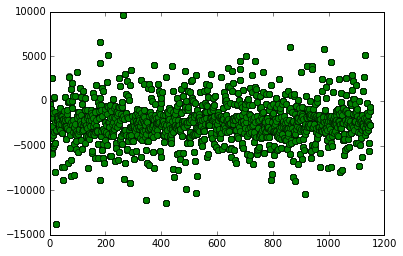

In [189]:
plt.plot(Y_pred,'go');

So, from the plot above, there are values above 0, even though my Y_train and Y_test are all below zero.

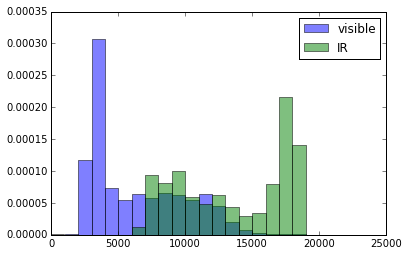

In [383]:
val = randint(0,2301)
_ = plt.hist(X_reduced[:,0:1972][val], alpha = 0.5, normed=True, bins=25, label='visible',range=(0,25000)) #visible light histogram
_ = plt.hist(X_reduced[:,1973:2476][val], alpha = 0.5, normed=True, bins=25, label='IR',range=(0,25000))
plt.legend(loc='upper right');

In [428]:
X_hist = []
for i in xrange(X_reduced.shape[0]):
    hist1, _ = np.histogram(X_reduced[:,0:1972][i], density=True, bins=25, range=(0,25000)) #vis
    hist2, _ = np.histogram(X_reduced[:,1973:2476][i], density=True, bins=25, range=(0,25000)) #IR
    X_hist.append(np.hstack((hist1,hist2)))
X_hist = np.array(X_hist)

Try random forest with new X_hist:

In [429]:
rfr = RandomForestRegressor(oob_score=True)
X_train, X_test, Y_train, Y_test = train_test_split(X_hist, Y_reduced, test_size = 0.3, random_state = 14)

In [430]:
rfr.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [431]:
print rfr.score(X_test,Y_test)
print rfr.oob_score_

0.174518399271
-0.00409222016671


In [432]:
from random import randint
val = randint(0,Y_test.shape[0])
print Y_pred[val]
print Y_test[val]

[-1736.63037127 -1735.83002907 -1735.87247932 -1735.86205807 -1735.87630777
 -1735.59226777 -1735.86062898]
[-4082.73808083 -4082.59797133 -4082.65399817 -4082.671105   -4082.67535783
 -4082.6016735  -4082.6695155 ]


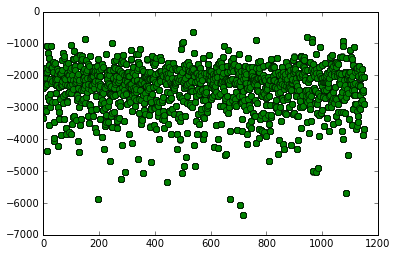

In [433]:
plt.plot(Y_pred,'go');

The score has improved (0.2) but the most remarkable is that all the predicted values are now below 0, as they should be.

Let's try something Extra Trees!

In [627]:
X_hist = []
for i in xrange(X_reduced.shape[0]):
    hist1, _ = np.histogram(X_reduced[:,0:1972][i], density=True, bins=30, range=(0,25000)) #vis
    hist2, _ = np.histogram(X_reduced[:,1973:2476][i], density=True, bins=30, range=(0,25000)) #IR
    X_hist.append(np.hstack((hist1,hist2)))
X_hist = np.array(X_hist)

In [628]:
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(oob_score=True, bootstrap=True, n_jobs=-1, n_estimators=100) #njobs uses all cores!
X_train, X_test, Y_train, Y_test = train_test_split(X_hist, Y_reduced, test_size = 0.3, random_state = 14)

In [629]:
etr.fit(X_train,Y_train)

ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
          verbose=0, warm_start=False)

In [630]:
print etr.score(X_test,Y_test)
print etr.oob_score_

0.237025258926
0.253519316664


In [633]:
from random import randint
val = randint(0,Y_test.shape[0])
print Y_pred[val]
print Y_test[val]

[-2085.4927687  -2084.31641815 -2084.36274315 -2084.35427948 -2084.396237
 -2083.90427887 -2084.35021117]
[-2099.20588867 -2098.90826783 -2098.97825067 -2098.99554717 -2099.00107567
 -2098.7010995  -2098.99597117]


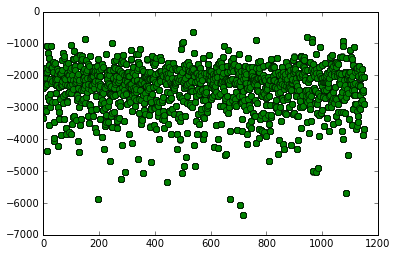

In [634]:
plt.plot(Y_pred,'go');

Not much better than random forest regressor, but does offer multicore support which speeds things up significantly. Edit: actually, this is better when increasing the number of n_estimators.

##Now with all channels!

In [636]:
with np.load('data/X_all_channels.npz') as data:
    X = data['X']
    
with np.load('data/Y_all_channels.npz') as data:
    Y = data['Y']

In [638]:
print X.shape
print Y.shape

(2544, 3988)
(2544, 14)


In [639]:
mask = []
for i,row in enumerate(Y):
    if row[0] == 0:
        mask.append(False)
    else:
        mask.append(True)    
mask = np.array(mask)
X_reduced = X[mask]
Y_reduced = Y[mask][:,-7::]

In [640]:
print X_reduced.shape
print Y_reduced.shape

(2302, 3988)
(2302, 7)


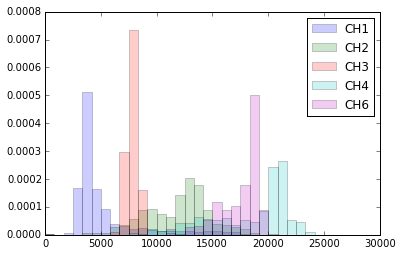

In [656]:
val = randint(0,2301)
_ = plt.hist(X_reduced[:,0:1972][val], alpha = 0.2, normed=True, bins=30, label='CH1',range=(0,25000)) #visible light histogram
_ = plt.hist(X_reduced[:,1973:2476][val], alpha = 0.2, normed=True, bins=30, label='CH2',range=(0,25000))
_ = plt.hist(X_reduced[:,2477:2980][val], alpha = 0.2, normed=True, bins=30, label='CH3',range=(0,25000))
_ = plt.hist(X_reduced[:,2981:3484][val], alpha = 0.2, normed=True, bins=30, label='CH4',range=(0,25000))
_ = plt.hist(X_reduced[:,3484:3988][val], alpha = 0.2, normed=True, bins=30, label='CH6',range=(0,25000))
plt.legend(loc='upper right');

In [737]:
X_hist = []
bins = 20
for i in xrange(X_reduced.shape[0]):
    hist1, _ = np.histogram(X_reduced[:,0:1972][i], density=True, bins=bins, range=(0,25000))
    hist2, _ = np.histogram(X_reduced[:,1973:2476][i], density=True, bins=bins, range=(0,25000))
    hist3, _ = np.histogram(X_reduced[:,2477:2980][i], density=True, bins=bins, range=(0,25000))
    hist4, _ = np.histogram(X_reduced[:,2981:3484][i], density=True, bins=bins, range=(0,25000))
    hist5, _ = np.histogram(X_reduced[:,3484:3988][i], density=True, bins=bins, range=(0,25000))
    X_hist.append(np.hstack((hist1,hist2,hist3,hist4,hist5)))
X_hist = np.array(X_hist)

In [738]:
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(
    oob_score=True, bootstrap=True, n_jobs=-1, n_estimators=1000
                         ) #nj_obs uses all cores!
X_train, X_test, Y_train, Y_test = train_test_split(X_hist, Y_reduced, test_size = 0.25, random_state = 12)

In [739]:
etr.fit(X_train,Y_train)

ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=1000, n_jobs=-1, oob_score=True, random_state=None,
          verbose=0, warm_start=False)

In [787]:
print etr.score(X_test,Y_test)
print etr.oob_score_

0.333571847511
0.324312054499


In [788]:
from random import randint
val = randint(0,Y_test.shape[0])
print Y_pred[val]
print Y_test[val]

[-3546.09800318 -3545.97880823 -3546.01557603 -3546.02564373 -3546.02913815
 -3545.91567287 -3546.02901358]
[-2216.3428045  -2216.22484817 -2216.2996965  -2216.32683533 -2216.336912
 -2216.22664033 -2216.33727767]


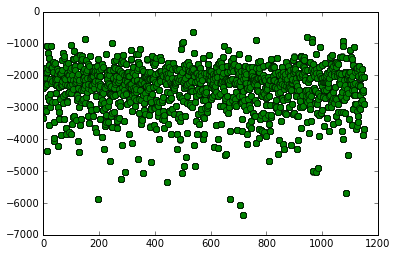

In [789]:
plt.plot(Y_pred,'go');

Wow, even better, but is it good enough?  If I include ratios between channels, spatial and other information will be implicitly collected.

Downsample CH1 and divide by CH6:

In [1091]:
from scipy.ndimage import zoom
from __future__ import division

X_reduced_ratio_1_2 = []
for i in xrange(X_reduced.shape[0]):
    CH1 = zoom(X_reduced[:,0:1972][i].reshape((29,68)),zoom=(0.48, 0.53), order=5)
    CH2 = X_reduced[:,1972:2476][i].reshape((14,36))
    X_reduced_ratio_1_2.append(25000* CH2  / (CH1 + CH2) )
X_reduced_ratio_1_2 = np.array(X_reduced_ratio_1_2)

X_reduced_ratio_1_6 = []
for i in xrange(X_reduced.shape[0]):
    CH1 = zoom(X_reduced[:,0:1972][i].reshape((29,68)),zoom=(0.48, 0.53), order=5)
    CH6 = X_reduced[:,3484:3988][i].reshape((14,36))
    X_reduced_ratio_1_6.append(25000* CH6 / (CH1 + CH6) )
X_reduced_ratio_1_6 = np.array(X_reduced_ratio_1_6)

X_reduced_ratio_2_6 = []
for i in xrange(X_reduced.shape[0]):
    CH2 = X_reduced[:,1972:2476][i].reshape((14,36))
    CH6 = X_reduced[:,3484:3988][i].reshape((14,36))
    X_reduced_ratio_2_6.append(25000* CH6 / (CH2 + CH6) )
X_reduced_ratio_2_6 = np.array(X_reduced_ratio_2_6)

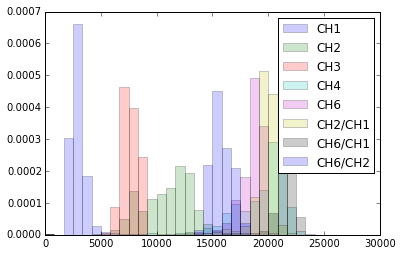

In [1093]:
val = randint(0,2301)
_ = plt.hist(X_reduced[:,0:1972][val], alpha = 0.2, normed=True, bins=30, label='CH1',range=(0,25000)) #visible light histogram
_ = plt.hist(X_reduced[:,1973:2476][val], alpha = 0.2, normed=True, bins=30, label='CH2',range=(0,25000))
_ = plt.hist(X_reduced[:,2477:2980][val], alpha = 0.2, normed=True, bins=30, label='CH3',range=(0,25000))
_ = plt.hist(X_reduced[:,2981:3484][val], alpha = 0.2, normed=True, bins=30, label='CH4',range=(0,25000))
_ = plt.hist(X_reduced[:,3484:3988][val], alpha = 0.2, normed=True, bins=30, label='CH6',range=(0,25000))
_ = plt.hist(np.ravel(X_reduced_ratio_1_2[val]), alpha = 0.2, normed=True, bins=30, label='CH2/CH1',range=(0,25000))
_ = plt.hist(np.ravel(X_reduced_ratio_1_6[val]), alpha = 0.2, normed=True, bins=30, label='CH6/CH1',range=(0,25000))
_ = plt.hist(np.ravel(X_reduced_ratio_2_6[val]), alpha = 0.2, normed=True, bins=30, label='CH6/CH2',range=(0,25000))
plt.legend(loc='upper right');

In [1101]:
X_hist = []
bins = 30
for i in xrange(X_reduced.shape[0]):
    hist1, _ = np.histogram(X_reduced[:,0:1972][i], density=True, bins=bins, range=(0,25000))
    hist2, _ = np.histogram(X_reduced[:,1972:2476][i], density=True, bins=bins, range=(0,25000))
    hist3, _ = np.histogram(X_reduced[:,2476:2980][i], density=True, bins=bins, range=(0,25000))
    hist4, _ = np.histogram(X_reduced[:,2980:3484][i], density=True, bins=bins, range=(0,25000))
    hist5, _ = np.histogram(X_reduced[:,3484:3988][i], density=True, bins=bins, range=(0,25000))
    hist6, _ = np.histogram(np.ravel(X_reduced_ratio_1_2[i]), density=True, bins=bins, range=(0,25000))
    hist7, _ = np.histogram(np.ravel(X_reduced_ratio_1_6[i]), density=True, bins=bins, range=(0,25000))
    hist8, _ = np.histogram(np.ravel(X_reduced_ratio_2_6[i]), density=True, bins=bins, range=(0,25000))
    X_hist.append(np.hstack((hist1,hist2,hist3,hist4,hist5,hist6,hist7,hist8)))
X_hist = np.array(X_hist)

In [1105]:
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(oob_score=True, bootstrap=True,
                          n_jobs=-1, n_estimators=1000) #nj_obs uses all cores!
X_train, X_test, Y_train, Y_test = train_test_split(X_hist, Y_reduced, test_size = 0.2, random_state = 12)

In [1106]:
etr.fit(X_train,Y_train)

ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=1000, n_jobs=-1, oob_score=True, random_state=None,
          verbose=0, warm_start=False)

In [1107]:
print etr.score(X_test,Y_test)
print etr.oob_score_

0.400992066327
0.302861512548


In [1114]:
from random import randint
val = randint(0,Y_test.shape[0])
print Y_pred[val]
print Y_test[val]

[-2111.35264935 -2111.33037278 -2111.33640548 -2111.33989697 -2111.34116932
 -2111.31844367 -2111.34136852]
[-1513.74919033 -1512.226391   -1512.269637   -1512.23218683 -1512.30237917
 -1511.73857267 -1512.27493883]


Try it all again with just X, not X_reduced?

In [1229]:
from scipy.ndimage import zoom
from __future__ import division

X_ratio_1_2 = []
for i in xrange(X.shape[0]):
    CH1 = zoom(X[:,0:1972][i].reshape((29,68)),zoom=(0.48, 0.53), order=5)
    CH2 = X[:,1972:2476][i].reshape((14,36))
    X_ratio_1_2.append(25000* (CH2)  / (CH1 + CH2+1.0) )
X_ratio_1_2 = np.array(X_ratio_1_2)

X_ratio_1_6 = []
for i in xrange(X.shape[0]):
    CH1 = zoom(X[:,0:1972][i].reshape((29,68)),zoom=(0.48, 0.53), order=5)
    CH6 = X[:,3484:3988][i].reshape((14,36))
    X_ratio_1_6.append(25000* CH6 / (CH1 + CH6 + 0.1) )
X_ratio_1_6 = np.array(X_ratio_1_6)

X_ratio_2_6 = []
for i in xrange(X.shape[0]):
    CH2 = X[:,1972:2476][i].reshape((14,36))
    CH6 = X[:,3484:3988][i].reshape((14,36))
    X_ratio_2_6.append(25000* CH6 / (CH2 + CH6 + 0.1) )
X_ratio_2_6 = np.array(X_ratio_2_6)

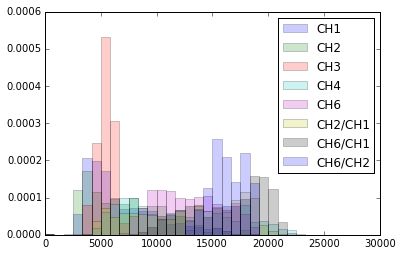

In [1230]:
val = randint(0,2301)
_ = plt.hist(X[:,0:1972][val], alpha = 0.2, normed=True, bins=30, label='CH1',range=(0,25000)) #visible light histogram
_ = plt.hist(X[:,1973:2476][val], alpha = 0.2, normed=True, bins=30, label='CH2',range=(0,25000))
_ = plt.hist(X[:,2477:2980][val], alpha = 0.2, normed=True, bins=30, label='CH3',range=(0,25000))
_ = plt.hist(X[:,2981:3484][val], alpha = 0.2, normed=True, bins=30, label='CH4',range=(0,25000))
_ = plt.hist(X[:,3484:3988][val], alpha = 0.2, normed=True, bins=30, label='CH6',range=(0,25000))
_ = plt.hist(np.ravel(X_ratio_1_2[val]), alpha = 0.2, normed=True, bins=30, label='CH2/CH1',range=(0,25000))
_ = plt.hist(np.ravel(X_ratio_1_6[val]), alpha = 0.2, normed=True, bins=30, label='CH6/CH1',range=(0,25000))
_ = plt.hist(np.ravel(X_ratio_2_6[val]), alpha = 0.2, normed=True, bins=30, label='CH6/CH2',range=(0,25000))
plt.legend(loc='upper right');

In [1236]:
import pandas as pd

X_hist = []
bins = 25
for i in xrange(X.shape[0]):
    myval1 = pd.DataFrame(np.ravel(X_ratio_1_2[i])).fillna(np.mean).values.flatten();
    myval2 = pd.DataFrame(np.ravel(X_ratio_1_6[i])).fillna(np.mean).values.flatten();
    myval3 = pd.DataFrame(np.ravel(X_ratio_2_6[i])).fillna(np.mean).values.flatten();
    
    hist1, _ = np.histogram(X[:,0:1972][i], density=True, bins=bins, range=(0,25000))
    hist2, _ = np.histogram(X[:,1972:2476][i], density=True, bins=bins, range=(0,25000))
    hist3, _ = np.histogram(X[:,2476:2980][i], density=True, bins=bins, range=(0,25000))
    hist4, _ = np.histogram(X[:,2980:3484][i], density=True, bins=bins, range=(0,25000))
    hist5, _ = np.histogram(X[:,3484:3988][i], density=True, bins=bins, range=(0,25000))
    hist6, _ = np.histogram( myval1 , density=True, bins=bins, range=(0,25000) )
    hist7, _ = np.histogram( myval2 , density=True, bins=bins, range=(0,25000))
    hist8, _ = np.histogram( myval3, density=True, bins=bins, range=(0,25000))
    X_hist.append(np.hstack((hist1,hist2,hist3,hist4,hist5,hist6,hist7,hist8)))
X_hist = np.array(X_hist)

In [1237]:
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(oob_score=True, bootstrap=True,
                          n_jobs=-1, n_estimators=500) #nj_obs uses all cores!
X_train, X_test, Y_train, Y_test = train_test_split(X_hist, Y, test_size = 0.2, random_state = 12)

In [1238]:
etr.fit(X_train,Y_train)

ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=500, n_jobs=-1, oob_score=True, random_state=None,
          verbose=0, warm_start=False)

In [1239]:
print etr.score(X_test,Y_test)
print etr.oob_score_

0.350322065473
0.452021910383


In [1242]:
Y_pred = etr.predict(X_test)

from random import randint
val = randint(0,Y_test.shape[0])
print Y_pred[val]
print Y_test[val]

[-2939.66263944 -2936.73025123 -2915.11887229 -2902.55734712 -2912.72887146
 -2929.26208371 -2919.29219376 -2255.328698   -2254.21816757 -2254.25603159
 -2254.24949458 -2254.29407376 -2253.80850048 -2254.21402432]
[-816.23915882 -816.13851593 -814.87584727 -814.35181418 -815.06576483
 -815.88368602 -815.46209638 -810.91360417 -808.76596733 -808.7843
 -808.86810717 -808.8855985  -808.18823617 -808.80836467]
